In [1]:
from train_dqn import DQN, ReplayMemory
from env import ElastisityEnv

import os
import math
import random

import numpy as np

from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



In [2]:
env = ElastisityEnv()


Observable pods/nodes:
raspberrypi1:193.2.205.204, ca: 10.1.245.9, pods: [('localization-api1', 'localization-api', '10.1.245.10')]
e6-orancloud:193.2.205.13, ca: 10.1.28.226, pods: []



In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

LOAD_WEIGHTS = True
SAVE_WEIGHTS = True
model_path = 'models/100ep_eff.pth'

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
# state, info = env.reset()
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)

if os.path.isfile(model_path) and LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load(model_path))
    print("Loaded weights from file.")
else:
    print("No weight file found, starting training from scratch.")

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(5000)


Loaded weights from file.


In [4]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [5]:

steps_done = 0
latencies_avg = []
avg_rewards = []
sum_rewards = []


In [7]:
if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    # state, info = env.reset()
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    episode_rewards = []
    latency = []
    for t in count():
        action = select_action(state)
        observation, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_rewards.append(reward.item())
        latency.append(info)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break
    avg_ep_reward = np.mean(episode_rewards)
    print(f"Episode {i_episode} reward: {avg_ep_reward}")
    avg_rewards.append(avg_ep_reward)
    sum_rewards.append(sum(episode_rewards))
    latencies_avg.append(np.mean(latency))

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), f'models/new_{model_path.split("/")[-1]}')

print(f'Complete with {np.mean(avg_rewards)} rewards and {np.mean(latencies_avg)} latency')


  0%|          | 0/50 [00:00<?, ?it/s]

Steps 0 Reward: -0.8220726084027974, State [0.028, 0.037033, 1.322607142857143]
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 1 Reward: 0.049909582491274196, State [0.054, 0.044207500000000004, 0.8186574074074074]
Steps 2 Reward: -0.758374700193052, State [0.054, 0.044207500000000004, 0.8186574074074074]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 3 Reward: -2.6468644354684012, State [0.028, 0.098324, 3.5115714285714286]
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 4 Reward: 0.9024724960327148, State [0.054, 0.0316645, 0.5863796296296296]
Steps 5 Reward: -0.3704331049036096, State [0.054, 0.06792400000000001, 1.2578518518518518]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 6 Reward: 0.0408840629577637, State [0.08, 0.06792400000000001, 0.84905]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 7 Reward: -1.3482313586643766, St

  2%|▏         | 1/50 [01:01<50:06, 61.35s/it]

Steps 49 Reward: 0.00597532812154522, State [0.106, 0.09617, 0.9072641509433962]
Max steps reached
Episode 0 reward: -0.4557187908980995
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 0 Reward: 0.8653817176818848, State [0.133, 0.059416, 0.44673684210526315]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 1 Reward: 0.8845744132995605, State [0.08, 0.057298499999999995, 0.71623125]
Steps 2 Reward: 0.15825128555297852, State [0.08, 0.057298499999999995, 0.71623125]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 3 Reward: -2.1641357105800085, State [0.028, 0.06957200000000001, 2.484714285714286]
Steps 4 Reward: -2.217787043435233, State [0.028, 0.06957200000000001, 2.484714285714286]
Steps 5 Reward: -0.3492943649291992, State [0.028, 0.025214, 0.9005]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 6 Reward: -0.5294314722333635, State [0.028, 0.028017, 1.000607142857

  4%|▍         | 2/50 [02:03<49:14, 61.56s/it]

Steps 49 Reward: -0.050295970210322616, State [0.054, 0.0511145, 0.9465648148148148]
Max steps reached
Episode 1 reward: -0.5716741969436407
Steps 0 Reward: -0.26116289831090855, State [0.054, 0.0511145, 0.9465648148148148]
Steps 1 Reward: 0.03858115005493157, State [0.054, 0.0466155, 0.8632500000000001]
Steps 2 Reward: -0.8325815789964464, State [0.054, 0.080511, 1.4909444444444444]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 3 Reward: -0.08264272384643556, State [0.08, 0.078719, 0.9839875]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 4 Reward: -2.2980409398760115, State [0.028, 0.078719, 2.8113928571428572]
Steps 5 Reward: -1.9859983629499163, State [0.028, 0.049969, 1.7846071428571428]
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 6 Reward: -0.07762677242137772, State [0.054, 0.052333, 0.9691296296296297]
Steps 7 Reward: 0.19060468673706055, State [0.054, 0.032990000000000005, 0.6109

  6%|▌         | 3/50 [03:04<48:10, 61.50s/it]

Steps 49 Reward: -1.2142262129607024, State [0.054, 0.046811, 0.8668703703703704]
Max steps reached
Episode 2 reward: -0.7488838601112365
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 0 Reward: -3.7175885434831892, State [0.028, 0.054513, 1.9468928571428572]
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 1 Reward: -0.620803478523537, State [0.054, 0.047578, 0.8810740740740741]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 2 Reward: 0.9125957489013672, State [0.08, 0.042173499999999996, 0.52716875]
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 3 Reward: 0.01272093841264832, State [0.106, 0.093904, 0.8858867924528302]
Steps 4 Reward: -0.4059397023039044, State [0.106, 0.093904, 0.8858867924528302]
Steps 5 Reward: 0.8967385292053223, State [0.106, 0.063378, 0.5979056603773585]
Steps 6 Reward: 0.8833250999450684, State [0.106, 0.061079, 0.5762169811320754]
Pod 

  8%|▊         | 4/50 [04:06<47:25, 61.85s/it]

Steps 49 Reward: -1.402091561162592, State [0.893, 0.090272, 0.10108846584546473]
Max steps reached
Episode 3 reward: -1.0492291713505983
Pod localization-api1 patched successfully to 943m request and 943m limit
Steps 0 Reward: -0.9993539244636658, State [0.945, 0.11229, 0.1188253968253968]
Pod localization-api1 patched successfully to 995m request and 995m limit
Steps 1 Reward: -1.0733251638469812, State [0.998, 0.061220500000000004, 0.06134318637274549]
Pod localization-api1 patched successfully to 1000m request and 1000m limit
Steps 2 Reward: -1.0360826893808368, State [0.998, 0.0656715, 0.06580310621242486]
Steps 3 Reward: -1.027401868915749, State [0.998, 0.0656715, 0.06580310621242486]
Pod localization-api1 patched successfully to 948m request and 948m limit
Steps 4 Reward: -0.9760815236046201, State [0.945, 0.107613, 0.11387619047619048]
Pod localization-api1 patched successfully to 995m request and 995m limit
Steps 5 Reward: -1.0667902083081569, State [0.998, 0.0676020000000000

 10%|█         | 5/50 [05:13<47:43, 63.64s/it]

Steps 49 Reward: -1.0507490821402659, State [0.893, 0.060500500000000006, 0.06774972004479284]
Max steps reached
Episode 4 reward: -1.14241943359375
Pod localization-api1 patched successfully to 943m request and 943m limit
Steps 0 Reward: -1.0384329854733099, State [0.945, 0.0589265, 0.06235608465608466]
Pod localization-api1 patched successfully to 895m request and 895m limit
Steps 1 Reward: -1.0513958811743929, State [0.893, 0.0589265, 0.06598712206047032]
Pod localization-api1 patched successfully to 943m request and 943m limit
Steps 2 Reward: -1.5022086125893568, State [0.945, 0.080194, 0.08486137566137567]
Steps 3 Reward: -1.340812735691777, State [0.945, 0.0405545, 0.042914814814814815]
Pod localization-api1 patched successfully to 895m request and 895m limit
Steps 4 Reward: -1.0396929997682305, State [0.893, 0.070331, 0.07875811870100784]
Steps 5 Reward: -1.4392078290215264, State [0.893, 0.110748, 0.12401791713325867]
Steps 6 Reward: -1.4929975901066523, State [0.893, 0.0498605

 12%|█▏        | 6/50 [06:19<47:14, 64.42s/it]

Steps 49 Reward: -0.592490202585856, State [0.054, 0.08136, 1.5066666666666666]
Max steps reached
Episode 5 reward: -0.7618666522949934
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 0 Reward: 0.12889957427978516, State [0.08, 0.060441, 0.7555125000000001]
Steps 1 Reward: 0.8908281326293945, State [0.08, 0.060441, 0.7555125000000001]
Pod localization-api1 patched successfully to 130m request and 130m limit
Error making prediction: {"detail":"Error making prediction"}
Steps 2 Reward: -4.0, State [0.106, 0.071122, 0.6709622641509434]
Steps 3 Reward: -0.019634476643688337, State [0.106, 0.095369, 0.8997075471698114]
Steps 4 Reward: 0.8723983764648438, State [0.106, 0.056322000000000004, 0.5313396226415095]
Pod localization-api1 patched successfully to 56m request and 56m limit
Steps 5 Reward: -0.12883784103393547, State [0.054, 0.056322000000000004, 1.043]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 6 Reward: 0.873447418

 14%|█▍        | 7/50 [07:25<46:23, 64.73s/it]

Steps 49 Reward: 0.8598337173461914, State [0.106, 0.0596985, 0.5631933962264151]
Max steps reached
Episode 6 reward: -0.2572429407760501
Steps 0 Reward: 0.8967838287353516, State [0.106, 0.045278, 0.4271509433962264]
Steps 1 Reward: -0.7279328776665455, State [0.106, 0.112259, 1.0590471698113209]
Steps 2 Reward: -0.20763201249320562, State [0.106, 0.112259, 1.0590471698113209]
Steps 3 Reward: 0.8813652992248535, State [0.106, 0.045644, 0.43060377358490565]
Steps 4 Reward: -1.011870544289643, State [0.106, 0.139142, 1.3126603773584906]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 5 Reward: -0.3874027373521849, State [0.133, 0.139142, 1.0461804511278197]
Steps 6 Reward: 0.9092006683349609, State [0.133, 0.060545499999999995, 0.4552293233082707]
Steps 7 Reward: -0.784694181313192, State [0.133, 0.0446925, 0.3360338345864662]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 8 Reward: -0.25696546478271487, State [0.08, 0.09058

 16%|█▌        | 8/50 [08:29<45:14, 64.63s/it]

Steps 49 Reward: 0.9092721939086914, State [0.133, 0.091655, 0.6891353383458647]
Max steps reached
Episode 7 reward: -0.27838045373559
Steps 0 Reward: 0.9072003364562988, State [0.133, 0.085788, 0.6450225563909775]
Steps 1 Reward: 0.899299144744873, State [0.133, 0.089936, 0.6762105263157895]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 2 Reward: -0.9662753479003907, State [0.08, 0.089936, 1.1242]
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 3 Reward: 0.8533916473388672, State [0.106, 0.061924999999999994, 0.5841981132075472]
Steps 4 Reward: 0.8675107955932617, State [0.106, 0.055582, 0.5243584905660378]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 5 Reward: 0.8966455459594727, State [0.133, 0.0783785, 0.589312030075188]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 6 Reward: -0.5873624565124512, State [0.08, 0.0783785, 0.97973125]
Pod localization-api1

 18%|█▊        | 9/50 [09:39<45:19, 66.33s/it]

Steps 49 Reward: -0.7550305716231063, State [0.185, 0.0635785, 0.34366756756756756]
Max steps reached
Episode 8 reward: -0.033334702383726836
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 0 Reward: -0.825551613610505, State [0.237, 0.0635785, 0.2682637130801688]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 1 Reward: -1.129975018731479, State [0.29, 0.0505925, 0.17445689655172417]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 2 Reward: 0.8277401924133301, State [0.237, 0.115748, 0.48838818565400843]
Steps 3 Reward: -0.8550179204659121, State [0.237, 0.0619675, 0.2614662447257384]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 4 Reward: -0.8613180626494974, State [0.237, 0.0610575, 0.257626582278481]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 5 Reward: -0.8082844881624789, State [0.185, 0.05714, 0.30886486486486486]
P

 20%|██        | 10/50 [10:49<44:55, 67.38s/it]

Steps 49 Reward: 0.6820592880249023, State [0.08, 0.047322499999999997, 0.59153125]
Max steps reached
Episode 9 reward: -0.22194788864813744
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 0 Reward: -2.0306464603969028, State [0.028, 0.078, 2.7857142857142856]
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 1 Reward: -0.035306072093822305, State [0.054, 0.0448045, 0.8297129629629629]
Steps 2 Reward: -0.6181474825541178, State [0.054, 0.081792, 1.5146666666666666]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 3 Reward: -0.25475622177124024, State [0.08, 0.086425, 1.0803125]
Steps 4 Reward: 0.884345531463623, State [0.08, 0.0416755, 0.52094375]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 5 Reward: -1.119955113002232, State [0.028, 0.056697000000000004, 2.024892857142857]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 6 Reward: -2.7

 22%|██▏       | 11/50 [11:59<44:24, 68.32s/it]

Steps 49 Reward: 0.7868680953979492, State [0.106, 0.066854, 0.6306981132075472]
Max steps reached
Episode 10 reward: -0.49234021320939064
Pod localization-api1 patched successfully to 56m request and 56m limit
Steps 0 Reward: -2.1050791664123536, State [0.054, 0.106218, 1.967]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 1 Reward: 0.8897862434387207, State [0.08, 0.0622615, 0.7782687500000001]
Steps 2 Reward: 0.880518913269043, State [0.08, 0.0622615, 0.7782687500000001]
Steps 3 Reward: 0.6974682807922363, State [0.08, 0.057581, 0.7197625]
Pod localization-api1 patched successfully to 50m request and 50m limit
Steps 4 Reward: -1.42907494027274, State [0.028, 0.064943, 2.3193928571428573]
Steps 5 Reward: -3.2982537471226285, State [0.028, 0.068167, 2.4345357142857145]
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 6 Reward: 0.7984075546264648, State [0.054, 0.0353085, 0.653861111111111]
Steps 7 Reward: -1.235325638241238

 24%|██▍       | 12/50 [13:10<43:42, 69.00s/it]

Steps 49 Reward: -2.836876138959612, State [0.028, 0.078185, 2.7923214285714284]
Max steps reached
Episode 11 reward: -0.5168799823522567
Pod localization-api1 patched successfully to 78m request and 78m limit
Steps 0 Reward: 0.9046540260314941, State [0.054, 0.0420475, 0.7786574074074075]
Steps 1 Reward: -1.0329771556147822, State [0.054, 0.081512, 1.5094814814814814]
Pod localization-api1 patched successfully to 104m request and 104m limit
Steps 2 Reward: 0.6528220176696777, State [0.08, 0.0384055, 0.48006875]
Steps 3 Reward: -0.3584813400268554, State [0.08, 0.100018, 1.250225]
Steps 4 Reward: -0.35136692962646476, State [0.08, 0.100018, 1.250225]
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 5 Reward: 0.9051928520202637, State [0.106, 0.0637685, 0.6015896226415094]
Steps 6 Reward: 0.04730735195807678, State [0.106, 0.09076300000000001, 0.8562547169811322]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 7 Reward: 0.68

 26%|██▌       | 13/50 [14:16<42:06, 68.28s/it]

Steps 49 Reward: -0.8702461498569798, State [0.185, 0.0427735, 0.2312081081081081]
Max steps reached
Episode 12 reward: 0.06653576016426087
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 0 Reward: -1.3523227813978236, State [0.237, 0.08981, 0.3789451476793249]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 1 Reward: 0.7736716270446777, State [0.185, 0.076211, 0.4119513513513514]
Steps 2 Reward: 0.864809513092041, State [0.185, 0.081315, 0.43954054054054054]
Steps 3 Reward: 0.3738722801208496, State [0.185, 0.081315, 0.43954054054054054]
Steps 4 Reward: 0.9213671684265137, State [0.185, 0.111689, 0.6037243243243243]
Steps 5 Reward: -1.252042134465398, State [0.185, 0.060735, 0.3282972972972973]
Steps 6 Reward: -1.2441458754668364, State [0.185, 0.05298, 0.2863783783783784]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 7 Reward: 0.7048139572143555, State [0.133, 0.09025799999999999, 0.6786

 28%|██▊       | 14/50 [15:25<40:58, 68.30s/it]

Steps 49 Reward: 0.7246170043945312, State [0.106, 0.057813, 0.5454056603773585]
Max steps reached
Episode 13 reward: 0.014761584606021642
Steps 0 Reward: 0.9112486839294434, State [0.106, 0.057813, 0.5454056603773585]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 1 Reward: 0.9015283584594727, State [0.133, 0.058781999999999994, 0.44196992481203007]
Steps 2 Reward: 0.8143410682678223, State [0.133, 0.101105, 0.7601879699248122]
Steps 3 Reward: 0.48526859283447266, State [0.133, 0.07415999999999999, 0.557593984962406]
Pod localization-api1 patched successfully to 183m request and 183m limit
Steps 4 Reward: -1.4587347352723818, State [0.185, 0.051789499999999995, 0.27994324324324327]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 5 Reward: 0.8992133140563965, State [0.133, 0.083453, 0.6274661654135338]
Steps 6 Reward: 0.8911786079406738, State [0.133, 0.0617815, 0.46452255639097745]
Steps 7 Reward: 0.8948788642883301, Sta

 30%|███       | 15/50 [16:31<39:28, 67.67s/it]

Steps 49 Reward: 0.8634004592895508, State [0.106, 0.0503395, 0.47490094339622646]
Max steps reached
Episode 14 reward: 0.14162402399815618
Steps 0 Reward: 0.42253828048706055, State [0.106, 0.0503395, 0.47490094339622646]
Steps 1 Reward: 0.4907975196838379, State [0.106, 0.06547549999999999, 0.6176933962264151]
Steps 2 Reward: 0.847569465637207, State [0.106, 0.07264, 0.6852830188679245]
Steps 3 Reward: 0.9057841300964355, State [0.106, 0.0480445, 0.45324999999999993]
Steps 4 Reward: 0.9009966850280762, State [0.106, 0.0480445, 0.45324999999999993]
Steps 5 Reward: -0.3228303141324025, State [0.106, 0.129989, 1.226311320754717]
Steps 6 Reward: 0.9008965492248535, State [0.106, 0.0492425, 0.4645518867924528]
Steps 7 Reward: 0.06982926120398181, State [0.106, 0.088336, 0.8333584905660377]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 8 Reward: 0.9028515815734863, State [0.133, 0.07338, 0.5517293233082706]
Steps 9 Reward: 0.8826885223388672, State [0.133,

 32%|███▏      | 16/50 [17:34<37:35, 66.34s/it]

Steps 49 Reward: -0.18059404793816647, State [0.185, 0.199041, 1.0758972972972973]
Max steps reached
Episode 15 reward: 0.2573824992775917
Steps 0 Reward: 0.49224233627319336, State [0.185, 0.111399, 0.6021567567567567]
Steps 1 Reward: 0.9067044258117676, State [0.185, 0.0997715, 0.5393054054054054]
Steps 2 Reward: 0.42922115325927734, State [0.185, 0.0997715, 0.5393054054054054]
Steps 3 Reward: -1.0382350352313068, State [0.185, 0.192756, 1.0419243243243244]
Steps 4 Reward: -0.4280578176962364, State [0.185, 0.152336, 0.823437837837838]
Steps 5 Reward: -0.6879426385209366, State [0.185, 0.193874, 1.0479675675675675]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 6 Reward: 0.8282027244567871, State [0.133, 0.10445, 0.7853383458646617]
Steps 7 Reward: -0.8924847842051571, State [0.133, 0.206186, 1.5502706766917294]
Pod localization-api1 patched successfully to 183m request and 183m limit
Steps 8 Reward: 0.8435330390930176, State [0.185, 0.110376999999999

 34%|███▍      | 17/50 [18:40<36:27, 66.30s/it]

Steps 49 Reward: -0.0508275032043457, State [0.08, 0.05688, 0.711]
Max steps reached
Episode 16 reward: -0.5645135872624815
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 0 Reward: -0.24857387420366406, State [0.106, 0.111789, 1.05461320754717]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 1 Reward: -0.9268074070636492, State [0.133, 0.166638, 1.2529172932330828]
Steps 2 Reward: 0.003943570359308923, State [0.133, 0.1195925, 0.8991917293233083]
Steps 3 Reward: 0.8883795738220215, State [0.133, 0.0699145, 0.525672932330827]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 4 Reward: -2.522666005706787, State [0.08, 0.196143, 2.4517875]
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 5 Reward: 0.9032735824584961, State [0.106, 0.0722185, 0.6813066037735848]
Steps 6 Reward: -0.3192150824204931, State [0.106, 0.127422, 1.2020943396226416]
Pod localization-api1 patc

 36%|███▌      | 18/50 [19:47<35:22, 66.33s/it]

Steps 49 Reward: 0.8504638671875, State [0.133, 0.089765, 0.6749248120300751]
Max steps reached
Episode 17 reward: -0.44232184485532344
Steps 0 Reward: 0.8659396171569824, State [0.133, 0.089765, 0.6749248120300751]
Steps 1 Reward: -0.015801247503524407, State [0.133, 0.1164715, 0.8757255639097744]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 2 Reward: -0.805317066192627, State [0.08, 0.134465, 1.6808125]
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 3 Reward: -0.35630980826323877, State [0.106, 0.112932, 1.0653962264150942]
Steps 4 Reward: -0.343144581776745, State [0.106, 0.08551099999999999, 0.8067075471698114]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 5 Reward: 0.7944831848144531, State [0.133, 0.078551, 0.590609022556391]
Steps 6 Reward: -0.9944552090293484, State [0.133, 0.154455, 1.1613157894736843]
Steps 7 Reward: -0.42220209818675114, State [0.133, 0.158912, 1.1948270676691

 38%|███▊      | 19/50 [20:49<33:36, 65.06s/it]

Steps 49 Reward: 0.8683881759643555, State [0.237, 0.1075565, 0.45382489451476793]
Max steps reached
Episode 18 reward: -0.002575501799583435
Steps 0 Reward: 0.3309783935546875, State [0.237, 0.154477, 0.6518016877637131]
Steps 1 Reward: 0.4760560989379883, State [0.237, 0.118784, 0.501198312236287]
Steps 2 Reward: 0.8816442489624023, State [0.237, 0.118784, 0.501198312236287]
Steps 3 Reward: 0.4181680679321289, State [0.237, 0.162492, 0.685620253164557]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 4 Reward: 0.7923779487609863, State [0.29, 0.175456, 0.6050206896551724]
Steps 5 Reward: -0.8579960338197905, State [0.29, 0.0750065, 0.25864310344827585]
Pod localization-api1 patched successfully to 340m request and 340m limit
Steps 6 Reward: 0.8639178276062012, State [0.342, 0.1387835, 0.4057997076023392]
Steps 7 Reward: 0.4828009605407715, State [0.342, 0.144475, 0.42244152046783623]
Steps 8 Reward: 0.8941922187805176, State [0.342, 0.212074, 0.62009941

 40%|████      | 20/50 [21:54<32:30, 65.02s/it]

Steps 49 Reward: -0.7578761212579135, State [0.29, 0.1011, 0.3486206896551724]
Max steps reached
Episode 19 reward: 0.19120971001684667
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 0 Reward: 0.46553945541381836, State [0.237, 0.101464, 0.42811814345991567]
Steps 1 Reward: 0.4890475273132324, State [0.237, 0.101464, 0.42811814345991567]
Error making prediction: {"detail":"Error making prediction"}
Steps 2 Reward: -4.0, State [0.237, 0.187996, 0.7932320675105485]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 3 Reward: 0.8961687088012695, State [0.29, 0.16527699999999998, 0.5699206896551724]
Steps 4 Reward: -1.0315978540880928, State [0.29, 0.081705, 0.2817413793103448]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 5 Reward: 0.9101161956787109, State [0.237, 0.175642, 0.7411054852320675]
Steps 6 Reward: 0.900975227355957, State [0.237, 0.09886199999999999, 0.4171392405063291]
Steps 7 Rew

 42%|████▏     | 21/50 [22:57<31:14, 64.62s/it]

Steps 49 Reward: 0.49628591537475586, State [0.185, 0.1025915, 0.5545486486486486]
Max steps reached
Episode 20 reward: 0.18764690665528178
Steps 0 Reward: 0.8990392684936523, State [0.185, 0.12423300000000001, 0.6715297297297298]
Steps 1 Reward: -0.02834069516980975, State [0.185, 0.17016399999999998, 0.9198054054054055]
Steps 2 Reward: -0.015332577494028499, State [0.185, 0.17016399999999998, 0.9198054054054055]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 3 Reward: -0.23882839240167375, State [0.133, 0.1250995, 0.9405977443609023]
Steps 4 Reward: -1.0498694443380026, State [0.133, 0.184553, 1.3876165413533834]
Pod localization-api1 patched successfully to 183m request and 183m limit
Steps 5 Reward: 0.4910740852355957, State [0.185, 0.08938750000000001, 0.48317567567567565]
Steps 6 Reward: 0.7201347351074219, State [0.185, 0.08938750000000001, 0.48317567567567565]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 7 Rewa

 44%|████▍     | 22/50 [23:59<29:45, 63.75s/it]

Steps 49 Reward: 0.4241905212402344, State [0.237, 0.09873749999999999, 0.4166139240506329]
Max steps reached
Episode 21 reward: 0.14687643442302942
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 0 Reward: 0.9006843566894531, State [0.185, 0.1296285, 0.7006945945945947]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 1 Reward: -0.16739480289829434, State [0.237, 0.229289, 0.9674641350210971]
Steps 2 Reward: -0.06964318546665371, State [0.237, 0.229289, 0.9674641350210971]
Steps 3 Reward: 0.8894047737121582, State [0.237, 0.10373099999999999, 0.43768354430379747]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 4 Reward: 0.8953962326049805, State [0.185, 0.1154595, 0.6241054054054054]
Steps 5 Reward: -0.2437133735656738, State [0.185, 0.187664, 1.0144]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 6 Reward: -0.5062152099896193, State [0.133, 0.187664, 1.41100

 46%|████▌     | 23/50 [25:02<28:30, 63.35s/it]

Steps 49 Reward: -0.4815907257286278, State [0.185, 0.251562, 1.3597945945945946]
Max steps reached
Episode 22 reward: 0.2938921505399048
Steps 0 Reward: 0.8704648017883301, State [0.185, 0.1121575, 0.6062567567567567]
Steps 1 Reward: 0.9016737937927246, State [0.185, 0.1121575, 0.6062567567567567]
Steps 2 Reward: 0.8520302772521973, State [0.185, 0.112066, 0.6057621621621622]
Steps 3 Reward: 0.8916363716125488, State [0.185, 0.13597499999999998, 0.735]
Steps 4 Reward: -0.052043701893574434, State [0.185, 0.17682499999999998, 0.9558108108108108]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 5 Reward: 0.8900055885314941, State [0.237, 0.17682499999999998, 0.7460970464135022]
Steps 6 Reward: 0.4567108154296875, State [0.237, 0.11418099999999999, 0.48177637130801687]
Steps 7 Reward: 0.9217891693115234, State [0.237, 0.1205975, 0.5088502109704641]
Steps 8 Reward: 0.4536137580871582, State [0.237, 0.16946799999999998, 0.7150548523206751]
Pod localization-ap

 48%|████▊     | 24/50 [26:02<27:01, 62.37s/it]

Steps 49 Reward: 0.8742222785949707, State [0.29, 0.147998, 0.5103379310344828]
Max steps reached
Episode 23 reward: 0.5322445712983608
Steps 0 Reward: 0.5029354095458984, State [0.29, 0.147998, 0.5103379310344828]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 1 Reward: -1.1185576523245637, State [0.237, 0.0910165, 0.38403586497890296]
Steps 2 Reward: -0.7079150284231965, State [0.237, 0.0910165, 0.38403586497890296]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 3 Reward: 0.8963618278503418, State [0.29, 0.19426300000000002, 0.6698724137931035]
Pod localization-api1 patched successfully to 240m request and 240m limit
Error making prediction: {"detail":"Error making prediction"}
Steps 4 Reward: -4.0, State [0.237, 0.13894399999999998, 0.5862616033755275]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 5 Reward: 0.8574066162109375, State [0.185, 0.1338285, 0.7233972972972973]
Steps 6 Rewar

 50%|█████     | 25/50 [27:07<26:19, 63.20s/it]

Steps 49 Reward: 0.8881936073303223, State [0.185, 0.131719, 0.7119945945945946]
Max steps reached
Episode 24 reward: -0.021038680970668792
Steps 0 Reward: -0.030089123102136406, State [0.185, 0.170184, 0.9199135135135134]
Steps 1 Reward: -0.309012145686794, State [0.185, 0.222015, 1.2000810810810811]
Steps 2 Reward: 0.47684526443481445, State [0.185, 0.0923855, 0.4993810810810811]
Steps 3 Reward: -0.05594881946460617, State [0.185, 0.163849, 0.8856702702702702]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 4 Reward: -0.7003026385773394, State [0.133, 0.13963499999999998, 1.0498872180451129]
Steps 5 Reward: 0.8566150665283203, State [0.133, 0.093548, 0.7033684210526316]
Steps 6 Reward: -0.6135849362997183, State [0.133, 0.141451, 1.0635413533834586]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 7 Reward: -0.8825092765808105, State [0.08, 0.141451, 1.7681375]
Pod localization-api1 patched successfully to 130m request and 

 52%|█████▏    | 26/50 [28:10<25:13, 63.05s/it]

Steps 49 Reward: 0.863286018371582, State [0.133, 0.078957, 0.5936616541353383]
Max steps reached
Episode 25 reward: 0.1086215398274362
Steps 0 Reward: -0.009156638554164376, State [0.133, 0.116755, 0.8778571428571429]
Steps 1 Reward: 0.8749709129333496, State [0.133, 0.1025545, 0.7710864661654135]
Pod localization-api1 patched successfully to 83m request and 83m limit
Steps 2 Reward: -0.8919438339233396, State [0.08, 0.123208, 1.5400999999999998]
Pod localization-api1 patched successfully to 130m request and 130m limit
Steps 3 Reward: 0.9137663841247559, State [0.106, 0.062137, 0.5861981132075472]
Steps 4 Reward: -0.7381361422268846, State [0.106, 0.14843299999999998, 1.4003113207547166]
Steps 5 Reward: -0.986751883956621, State [0.106, 0.14843299999999998, 1.4003113207547166]
Pod localization-api1 patched successfully to 156m request and 156m limit
Steps 6 Reward: -0.6443110056999035, State [0.133, 0.14939599999999997, 1.1232781954887219]
Steps 7 Reward: -0.6723633357169934, State [0

 54%|█████▍    | 27/50 [29:13<24:14, 63.24s/it]

Steps 49 Reward: -1.1658907577251567, State [0.29, 0.1037075, 0.35761206896551717]
Max steps reached
Episode 26 reward: 0.027556634154170753
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 0 Reward: 0.8900961875915527, State [0.237, 0.1031615, 0.4352805907172996]
Steps 1 Reward: 0.4690704345703125, State [0.237, 0.1031615, 0.4352805907172996]
Steps 2 Reward: 0.9158287048339844, State [0.237, 0.174249, 0.7352278481012658]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 3 Reward: 0.8847150802612305, State [0.185, 0.092392, 0.49941621621621624]
Steps 4 Reward: 0.44179296493530273, State [0.185, 0.09047799999999999, 0.4890702702702703]
Steps 5 Reward: -0.08211348998611046, State [0.185, 0.185052, 1.0002810810810812]
Steps 6 Reward: 0.8661684989929199, State [0.185, 0.13769399999999998, 0.7442918918918919]
Steps 7 Reward: 0.884335994720459, State [0.185, 0.12083799999999999, 0.6531783783783783]
Steps 8 Reward: 0.906773567199707

 56%|█████▌    | 28/50 [30:19<23:27, 63.99s/it]

Steps 49 Reward: -0.5711478255813186, State [0.185, 0.173236, 0.9364108108108108]
Max steps reached
Episode 27 reward: 0.13117621842771768
Steps 0 Reward: 0.3436121940612793, State [0.185, 0.10896850000000001, 0.5890189189189189]
Steps 1 Reward: 0.8904132843017578, State [0.185, 0.10896850000000001, 0.5890189189189189]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 2 Reward: 0.4954061508178711, State [0.237, 0.1217305, 0.5136308016877638]
Steps 3 Reward: 0.9080657958984375, State [0.237, 0.162319, 0.6848902953586498]
Steps 4 Reward: 0.8430323600769043, State [0.237, 0.162319, 0.6848902953586498]
Steps 5 Reward: 0.44689273834228516, State [0.237, 0.1175245, 0.49588396624472575]
Steps 6 Reward: 0.8737311363220215, State [0.237, 0.10645, 0.44915611814345996]
Steps 7 Reward: 0.8968935012817383, State [0.237, 0.106486, 0.4493080168776371]
Steps 8 Reward: 0.8900032043457031, State [0.237, 0.106486, 0.4493080168776371]
Pod localization-api1 patched successfull

 58%|█████▊    | 29/50 [31:20<22:07, 63.21s/it]

Steps 49 Reward: 0.8805403709411621, State [0.237, 0.1025085, 0.4325253164556962]
Max steps reached
Episode 28 reward: 0.36903780643828216
Steps 0 Reward: 0.8932504653930664, State [0.237, 0.167251, 0.7057004219409283]
Steps 1 Reward: 0.9013757705688477, State [0.237, 0.167251, 0.7057004219409283]
Steps 2 Reward: 0.8972225189208984, State [0.237, 0.109012, 0.4599662447257383]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 3 Reward: 0.4371318817138672, State [0.29, 0.116488, 0.4016827586206897]
Pod localization-api1 patched successfully to 340m request and 340m limit
Steps 4 Reward: -0.7574659272801807, State [0.342, 0.1156675, 0.3382090643274854]
Steps 5 Reward: -0.7608323976170948, State [0.342, 0.1156675, 0.3382090643274854]
Pod localization-api1 patched successfully to 392m request and 392m limit
Steps 6 Reward: 0.8932886123657227, State [0.395, 0.225648, 0.5712607594936708]
Steps 7 Reward: -0.9034104112359542, State [0.395, 0.078378, 0.1984253164556

 60%|██████    | 30/50 [32:20<20:45, 62.29s/it]

Steps 49 Reward: 0.9005961418151855, State [0.29, 0.1206515, 0.41603965517241387]
Max steps reached
Episode 29 reward: 0.20887591809034348
Steps 0 Reward: 0.8939800262451172, State [0.29, 0.1170665, 0.4036775862068966]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 1 Reward: 0.40711021423339844, State [0.237, 0.1228235, 0.5182426160337553]
Steps 2 Reward: 0.8915195465087891, State [0.237, 0.1228235, 0.5182426160337553]
Steps 3 Reward: 0.9009227752685547, State [0.237, 0.1136495, 0.4795337552742616]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 4 Reward: -0.049558274160849125, State [0.185, 0.17644900000000002, 0.9537783783783784]
Steps 5 Reward: 0.4719576835632324, State [0.185, 0.09018300000000001, 0.4874756756756756]
Steps 6 Reward: 0.07492761263460723, State [0.185, 0.150976, 0.8160864864864865]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 7 Reward: 0.8996686935424805, State [0.237,

 62%|██████▏   | 31/50 [33:20<19:26, 61.39s/it]

Steps 49 Reward: 0.8940587043762207, State [0.29, 0.185083, 0.6382172413793104]
Max steps reached
Episode 30 reward: 0.3027445600181818
Steps 0 Reward: 0.9078083038330078, State [0.29, 0.137548, 0.474303448275862]
Steps 1 Reward: 0.899749755859375, State [0.29, 0.17812899999999998, 0.6142379310344828]
Steps 2 Reward: 0.9037981033325195, State [0.29, 0.17812899999999998, 0.6142379310344828]
Steps 3 Reward: 0.45578813552856445, State [0.29, 0.127548, 0.4398206896551724]
Pod localization-api1 patched successfully to 340m request and 340m limit
Steps 4 Reward: -1.1853840224282783, State [0.342, 0.1128855, 0.33007456140350877]
Pod localization-api1 patched successfully to 292m request and 292m limit
Steps 5 Reward: -0.7154101797695818, State [0.29, 0.1128855, 0.38926034482758626]
Steps 6 Reward: -0.8578378695520861, State [0.29, 0.0682855, 0.23546724137931035]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 7 Reward: -0.8094149523224006, State [0.237, 0.06828

 64%|██████▍   | 32/50 [34:19<18:11, 60.64s/it]

Steps 49 Reward: 0.9030733108520508, State [0.237, 0.175144, 0.7390042194092827]
Max steps reached
Episode 31 reward: 0.46936368763446806
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 0 Reward: 0.4663262367248535, State [0.29, 0.1166735, 0.40232241379310346]
Steps 1 Reward: 0.4451117515563965, State [0.29, 0.129659, 0.4471]
Steps 2 Reward: 0.8996996879577637, State [0.29, 0.146603, 0.5055275862068965]
Steps 3 Reward: 0.9033164978027344, State [0.29, 0.182346, 0.6287793103448276]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 4 Reward: -0.7284765121041472, State [0.237, 0.0876815, 0.36996413502109704]
Steps 5 Reward: -1.1128644820748503, State [0.237, 0.0876815, 0.36996413502109704]
Steps 6 Reward: 0.9052882194519043, State [0.237, 0.18794, 0.7929957805907173]
Steps 7 Reward: 0.4648599624633789, State [0.237, 0.11191899999999999, 0.4722320675105485]
Steps 8 Reward: 0.8956942558288574, State [0.237, 0.138983, 0.5864261603

 66%|██████▌   | 33/50 [35:17<17:01, 60.07s/it]

Steps 49 Reward: 0.8921871185302734, State [0.237, 0.137465, 0.5800210970464135]
Max steps reached
Episode 32 reward: 0.34104639895260336
Steps 0 Reward: 0.42369699478149414, State [0.237, 0.12665300000000002, 0.5344008438818565]
Steps 1 Reward: 0.9184083938598633, State [0.237, 0.156547, 0.6605358649789029]
Steps 2 Reward: 0.49535131454467773, State [0.237, 0.156547, 0.6605358649789029]
Steps 3 Reward: 0.8593020439147949, State [0.237, 0.18454900000000002, 0.7786877637130801]
Steps 4 Reward: 0.8962688446044922, State [0.237, 0.112595, 0.475084388185654]
Steps 5 Reward: 0.4615507125854492, State [0.237, 0.112595, 0.475084388185654]
Steps 6 Reward: 0.9113893508911133, State [0.237, 0.11645950000000001, 0.49139029535864975]
Steps 7 Reward: 0.8879718780517578, State [0.237, 0.11645950000000001, 0.49139029535864975]
Steps 8 Reward: 0.8619341850280762, State [0.237, 0.11630700000000001, 0.49074683544303793]
Steps 9 Reward: 0.9137997627258301, State [0.237, 0.137132, 0.5786160337552743]
Pod 

 68%|██████▊   | 34/50 [36:15<15:49, 59.34s/it]

Steps 49 Reward: 0.4361758232116699, State [0.237, 0.144323, 0.608957805907173]
Max steps reached
Episode 33 reward: 0.4020912731066346
Steps 0 Reward: 0.03069072538287332, State [0.237, 0.20786500000000002, 0.8770675105485232]
Steps 1 Reward: -0.02156109041302512, State [0.237, 0.20786500000000002, 0.8770675105485232]
Steps 2 Reward: -0.6905624107167692, State [0.237, 0.0914325, 0.3857911392405063]
Steps 3 Reward: 0.5098066329956055, State [0.237, 0.1163305, 0.49084599156118147]
Steps 4 Reward: -0.017657022741776607, State [0.237, 0.21762600000000001, 0.9182531645569622]
Steps 5 Reward: -0.016913156774979732, State [0.237, 0.21762600000000001, 0.9182531645569622]
Steps 6 Reward: 0.8505163192749023, State [0.237, 0.1016045, 0.42871097046413503]
Steps 7 Reward: 0.7716045379638672, State [0.237, 0.138902, 0.586084388185654]
Steps 8 Reward: 0.9037337303161621, State [0.237, 0.1011765, 0.42690506329113925]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 9 Re

 70%|███████   | 35/50 [37:13<14:43, 58.91s/it]

Steps 49 Reward: 0.8968839645385742, State [0.185, 0.1039605, 0.5619486486486487]
Max steps reached
Episode 34 reward: 0.25792987547814844
Steps 0 Reward: 0.40502405166625977, State [0.185, 0.0893285, 0.48285675675675677]
Steps 1 Reward: 0.8987245559692383, State [0.185, 0.110381, 0.596654054054054]
Steps 2 Reward: 0.8891973495483398, State [0.185, 0.110381, 0.596654054054054]
Steps 3 Reward: -0.13509517218100053, State [0.185, 0.193174, 1.0441837837837837]
Steps 4 Reward: 0.09703355205638986, State [0.185, 0.14938200000000001, 0.8074702702702703]
Steps 5 Reward: 0.08533196819408517, State [0.185, 0.14938200000000001, 0.8074702702702703]
Steps 6 Reward: 0.8951578140258789, State [0.185, 0.1147025, 0.6200135135135135]
Steps 7 Reward: -0.5386224824647645, State [0.185, 0.148362, 0.8019567567567567]
Steps 8 Reward: 0.49111461639404297, State [0.185, 0.113447, 0.613227027027027]
Steps 9 Reward: 0.5306634902954102, State [0.185, 0.13705, 0.7408108108108108]
Steps 10 Reward: 0.89877939224243

 72%|███████▏  | 36/50 [38:11<13:39, 58.57s/it]

Steps 49 Reward: 0.07033702712187884, State [0.185, 0.15459299999999998, 0.835637837837838]
Max steps reached
Episode 35 reward: 0.27061403676867485
Steps 0 Reward: 0.4840216636657715, State [0.185, 0.1008935, 0.5453702702702703]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 1 Reward: 0.8831605911254883, State [0.237, 0.1008935, 0.4257109704641351]
Steps 2 Reward: 0.8974227905273438, State [0.237, 0.1305065, 0.5506603375527426]
Steps 3 Reward: 0.9051904678344727, State [0.237, 0.152669, 0.6441729957805907]
Steps 4 Reward: -0.7877182917051677, State [0.237, 0.07833, 0.3305063291139241]
Steps 5 Reward: 0.9198532104492188, State [0.237, 0.137795, 0.5814135021097047]
Steps 6 Reward: 0.9143433570861816, State [0.237, 0.137795, 0.5814135021097047]
Steps 7 Reward: 0.8961448669433594, State [0.237, 0.1268845, 0.5353776371308017]
Steps 8 Reward: 0.9027299880981445, State [0.237, 0.1268845, 0.5353776371308017]
Steps 9 Reward: 0.8890018463134766, State [0.237, 0.

 74%|███████▍  | 37/50 [39:09<12:38, 58.34s/it]

Steps 49 Reward: 0.8905467987060547, State [0.185, 0.112253, 0.606772972972973]
Max steps reached
Episode 36 reward: 0.392252392959781
Steps 0 Reward: 0.905540943145752, State [0.185, 0.112253, 0.606772972972973]
Steps 1 Reward: 0.8778343200683594, State [0.185, 0.1117315, 0.603954054054054]
Steps 2 Reward: -0.06525648898562875, State [0.185, 0.166491, 0.8999513513513514]
Steps 3 Reward: 0.8961353302001953, State [0.185, 0.140542, 0.7596864864864865]
Steps 4 Reward: 0.8777246475219727, State [0.185, 0.129239, 0.6985891891891892]
Steps 5 Reward: 0.04151384656751478, State [0.185, 0.15443700000000002, 0.8347945945945946]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 6 Reward: 0.3696308135986328, State [0.237, 0.15443700000000002, 0.6516329113924051]
Steps 7 Reward: 0.8496723175048828, State [0.237, 0.126272, 0.5327932489451477]
Steps 8 Reward: 0.9013638496398926, State [0.237, 0.15620900000000001, 0.6591097046413502]
Steps 9 Reward: -1.2503056402407617, 

 76%|███████▌  | 38/50 [40:09<11:46, 58.84s/it]

Steps 49 Reward: 0.8121547698974609, State [0.185, 0.107038, 0.5785837837837838]
Max steps reached
Episode 37 reward: 0.11858544640243053
Steps 0 Reward: -0.8275019558674581, State [0.185, 0.186162, 1.0062810810810812]
Steps 1 Reward: 0.8635029792785645, State [0.185, 0.074261, 0.4014108108108108]
Steps 2 Reward: 0.8799586296081543, State [0.185, 0.074261, 0.4014108108108108]
Steps 3 Reward: 0.8906731605529785, State [0.185, 0.128836, 0.6964108108108108]
Steps 4 Reward: -0.7118529155215703, State [0.185, 0.210958, 1.1403135135135136]
Steps 5 Reward: 0.8977231979370117, State [0.185, 0.0910165, 0.4919810810810811]
Steps 6 Reward: 0.02701987298501507, State [0.185, 0.160688, 0.8685837837837838]
Steps 7 Reward: -0.43514262167440876, State [0.185, 0.160688, 0.8685837837837838]
Steps 8 Reward: 0.7510766983032227, State [0.185, 0.121004, 0.6540756756756757]
Steps 9 Reward: 0.9013233184814453, State [0.185, 0.121004, 0.6540756756756757]
Steps 10 Reward: -0.7232006817998113, State [0.185, 0.22

 78%|███████▊  | 39/50 [41:06<10:44, 58.57s/it]

Steps 49 Reward: -1.1517665598639126, State [0.29, 0.1083525, 0.3736293103448276]
Max steps reached
Episode 38 reward: 0.2436627080757171
Steps 0 Reward: 0.8697376251220703, State [0.29, 0.14174, 0.4887586206896552]
Steps 1 Reward: -1.1867979135710618, State [0.29, 0.104459, 0.3602034482758621]
Steps 2 Reward: -0.7527020540434739, State [0.29, 0.104459, 0.3602034482758621]
Steps 3 Reward: 0.8044276237487793, State [0.29, 0.215718, 0.7438551724137931]
Steps 4 Reward: 0.8647856712341309, State [0.29, 0.12807400000000002, 0.4416344827586207]
Steps 5 Reward: 0.8892378807067871, State [0.29, 0.12807400000000002, 0.4416344827586207]
Steps 6 Reward: 0.8894405364990234, State [0.29, 0.13785, 0.4753448275862069]
Steps 7 Reward: 0.900352954864502, State [0.29, 0.13785, 0.4753448275862069]
Steps 8 Reward: -1.1050887868683914, State [0.29, 0.11556399999999999, 0.39849655172413795]
Steps 9 Reward: 0.9133729934692383, State [0.29, 0.14291, 0.49279310344827587]
Steps 10 Reward: 0.8879075050354004, St

 80%|████████  | 40/50 [42:06<09:48, 58.82s/it]

Steps 49 Reward: -0.018522876986941883, State [0.185, 0.168338, 0.9099351351351352]
Max steps reached
Episode 39 reward: 0.06274026729166508
Steps 0 Reward: 0.8872828483581543, State [0.185, 0.11683, 0.6315135135135135]
Steps 1 Reward: 0.896695613861084, State [0.185, 0.11683, 0.6315135135135135]
Steps 2 Reward: 0.46062326431274414, State [0.185, 0.08615099999999999, 0.4656810810810811]
Steps 3 Reward: -0.16897512380239132, State [0.185, 0.19409200000000001, 1.049145945945946]
Steps 4 Reward: -0.05542470152571399, State [0.185, 0.151338, 0.8180432432432433]
Steps 5 Reward: 0.8604774475097656, State [0.185, 0.12231399999999999, 0.6611567567567568]
Steps 6 Reward: 0.892578125, State [0.185, 0.1048365, 0.5666837837837838]
Steps 7 Reward: 0.8633193969726562, State [0.185, 0.1048365, 0.5666837837837838]
Pod localization-api1 patched successfully to 135m request and 135m limit
Steps 8 Reward: 0.7986364364624023, State [0.133, 0.0965085, 0.7256278195488722]
Steps 9 Reward: -0.1067503594993648

 82%|████████▏ | 41/50 [43:03<08:45, 58.43s/it]

Steps 49 Reward: 0.4842052459716797, State [0.237, 0.100663, 0.42473839662447255]
Max steps reached
Episode 40 reward: 0.3468964096903801
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 0 Reward: -0.7755954811885439, State [0.29, 0.100663, 0.34711379310344825]
Steps 1 Reward: 0.9149370193481445, State [0.29, 0.22299000000000002, 0.7689310344827586]
Steps 2 Reward: -0.840059991534003, State [0.29, 0.072852, 0.25121379310344827]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 3 Reward: -0.10304964488870483, State [0.237, 0.238337, 1.0056413502109705]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 4 Reward: -1.2578318382000102, State [0.29, 0.08582899999999999, 0.29596206896551724]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 5 Reward: 0.05425298711720383, State [0.237, 0.200663, 0.8466793248945149]
Steps 6 Reward: 0.5056033134460449, State [0.237, 0.126082, 

 84%|████████▍ | 42/50 [44:03<07:49, 58.72s/it]

Steps 49 Reward: -0.7171170793364321, State [0.237, 0.09145350000000001, 0.385879746835443]
Max steps reached
Episode 41 reward: 0.3661693761497736
Steps 0 Reward: 0.44978952407836914, State [0.237, 0.1033355, 0.43601476793248944]
Steps 1 Reward: 0.03836942215609651, State [0.237, 0.202691, 0.8552362869198312]
Steps 2 Reward: -0.3753631065304269, State [0.237, 0.202691, 0.8552362869198312]
Steps 3 Reward: 0.9043583869934082, State [0.237, 0.13313, 0.5617299578059072]
Steps 4 Reward: -0.727410329166847, State [0.237, 0.088419, 0.3730759493670886]
Steps 5 Reward: -0.7536411412396009, State [0.237, 0.088419, 0.3730759493670886]
Steps 6 Reward: 0.09186758014019025, State [0.237, 0.190538, 0.803957805907173]
Steps 7 Reward: 0.4656038284301758, State [0.237, 0.11284699999999999, 0.4761476793248945]
Steps 8 Reward: 0.8942852020263672, State [0.237, 0.11284699999999999, 0.4761476793248945]
Steps 9 Reward: 0.8735332489013672, State [0.237, 0.1108865, 0.46787552742616034]
Steps 10 Reward: 0.4272

 86%|████████▌ | 43/50 [45:00<06:47, 58.18s/it]

Steps 49 Reward: 0.8181009292602539, State [0.237, 0.1695, 0.7151898734177216]
Max steps reached
Episode 42 reward: 0.27331223629415036
Steps 0 Reward: -0.7853260507543378, State [0.237, 0.0749755, 0.3163523206751055]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 1 Reward: -0.6630187640009699, State [0.185, 0.209444, 1.1321297297297297]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 2 Reward: -0.013563179241454004, State [0.237, 0.209444, 0.8837299578059071]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 3 Reward: 0.9028968811035156, State [0.185, 0.1109735, 0.5998567567567568]
Steps 4 Reward: 0.8577737808227539, State [0.185, 0.1162105, 0.6281648648648649]
Steps 5 Reward: 0.8904228210449219, State [0.185, 0.135547, 0.7326864864864865]
Steps 6 Reward: 0.9086189270019531, State [0.185, 0.085039, 0.45967027027027024]
Steps 7 Reward: 0.4782900810241699, State [0.185, 0.085039, 0.45967027027

 88%|████████▊ | 44/50 [45:59<05:50, 58.50s/it]

Steps 49 Reward: -0.8244122095872581, State [0.237, 0.0714095, 0.30130590717299577]
Max steps reached
Episode 43 reward: 0.3592472469620407
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 0 Reward: 0.8219203948974609, State [0.185, 0.113581, 0.6139513513513514]
Steps 1 Reward: 0.07818536531603015, State [0.185, 0.148815, 0.8044054054054054]
Steps 2 Reward: 0.01986579668199695, State [0.185, 0.148815, 0.8044054054054054]
Steps 3 Reward: 0.7461748123168945, State [0.185, 0.089726, 0.48500540540540543]
Steps 4 Reward: -0.1852305810051995, State [0.185, 0.201016, 1.086572972972973]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 5 Reward: -0.7929275803384901, State [0.237, 0.081726, 0.34483544303797475]
Steps 6 Reward: 0.4083881378173828, State [0.237, 0.11241200000000001, 0.4743122362869198]
Pod localization-api1 patched successfully to 287m request and 287m limit
Steps 7 Reward: 0.8859643936157227, State [0.29, 0.170446, 0.5

 90%|█████████ | 45/50 [47:00<04:56, 59.27s/it]

Steps 49 Reward: -0.9347326570824732, State [0.237, 0.051465000000000004, 0.21715189873417726]
Max steps reached
Episode 44 reward: 0.14126455545425415
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 0 Reward: -0.22747970310932875, State [0.185, 0.20400100000000002, 1.102708108108108]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 1 Reward: -0.9612556370441421, State [0.237, 0.076414, 0.32242194092827003]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 2 Reward: -0.27814730981362823, State [0.185, 0.211754, 1.1446162162162161]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 3 Reward: -0.4093740672662791, State [0.237, 0.211754, 0.8934767932489451]
Steps 4 Reward: 0.8768353462219238, State [0.237, 0.1163835, 0.4910696202531646]
Steps 5 Reward: 0.8526978492736816, State [0.237, 0.140818, 0.594168776371308]
Steps 6 Reward: -0.7953523324250169, State [0.237, 0.07

 92%|█████████▏| 46/50 [48:03<04:01, 60.33s/it]

Steps 49 Reward: 0.8180937767028809, State [0.29, 0.1185235, 0.40870172413793104]
Max steps reached
Episode 45 reward: -0.06027109421789646
Steps 0 Reward: 0.8415040969848633, State [0.29, 0.1165715, 0.4019706896551724]
Steps 1 Reward: 0.9046826362609863, State [0.29, 0.161529, 0.556996551724138]
Steps 2 Reward: 0.9045133590698242, State [0.29, 0.161529, 0.556996551724138]
Steps 3 Reward: -1.1955115741598195, State [0.29, 0.1087155, 0.37488103448275856]
Steps 4 Reward: 0.8928499221801758, State [0.29, 0.172329, 0.5942379310344827]
Steps 5 Reward: -1.264563313688081, State [0.29, 0.09157299999999999, 0.3157689655172414]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 6 Reward: -0.058460876835046305, State [0.237, 0.215531, 0.9094135021097045]
Steps 7 Reward: -0.032525703800378336, State [0.237, 0.215531, 0.9094135021097045]
Steps 8 Reward: 0.8198962211608887, State [0.237, 0.1029835, 0.4345295358649789]
Steps 9 Reward: 0.8645853996276855, State [0.237, 0.

 94%|█████████▍| 47/50 [49:02<02:59, 59.85s/it]

Steps 49 Reward: -0.28815865177846656, State [0.237, 0.230683, 0.9733459915611814]
Max steps reached
Episode 46 reward: 0.2111357320472598
Steps 0 Reward: -0.7537052388895413, State [0.237, 0.0890135, 0.375584388185654]
Steps 1 Reward: 0.883430004119873, State [0.237, 0.178387, 0.7526877637130802]
Steps 2 Reward: -0.2216872438358355, State [0.237, 0.257919, 1.08826582278481]
Steps 3 Reward: -1.2486042027050936, State [0.237, 0.0840045, 0.3544493670886076]
Steps 4 Reward: -0.7431234364087069, State [0.237, 0.0840045, 0.3544493670886076]
Steps 5 Reward: -0.1266574517905963, State [0.237, 0.24365799999999999, 1.0280928270042193]
Steps 6 Reward: -0.7259908474467474, State [0.237, 0.0908495, 0.383331223628692]
Steps 7 Reward: -0.739356592991181, State [0.237, 0.0908495, 0.383331223628692]
Steps 8 Reward: -0.19493520527449348, State [0.237, 0.242165, 1.0217932489451478]
Steps 9 Reward: -1.2008484213140946, State [0.237, 0.0887505, 0.3744746835443038]
Steps 10 Reward: 0.8988866806030273, Stat

 96%|█████████▌| 48/50 [49:59<01:58, 59.14s/it]

Steps 49 Reward: 0.8951125144958496, State [0.237, 0.1036645, 0.4374029535864979]
Max steps reached
Episode 47 reward: 0.2197275042720139
Steps 0 Reward: 0.8667788505554199, State [0.237, 0.147686, 0.6231476793248946]
Steps 1 Reward: 0.9022054672241211, State [0.237, 0.147686, 0.6231476793248946]
Steps 2 Reward: 0.9165201187133789, State [0.237, 0.12938249999999998, 0.5459177215189873]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 3 Reward: -0.26616945266723624, State [0.185, 0.21275, 1.15]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 4 Reward: -0.7140997295299161, State [0.237, 0.093071, 0.392704641350211]
Pod localization-api1 patched successfully to 187m request and 187m limit
Steps 5 Reward: -0.8831560723588274, State [0.185, 0.24504499999999999, 1.3245675675675677]
Pod localization-api1 patched successfully to 235m request and 235m limit
Steps 6 Reward: -1.1872373744948503, State [0.237, 0.09454900000000001, 0.39

 98%|█████████▊| 49/50 [50:59<00:59, 59.29s/it]

Steps 49 Reward: 0.7400379180908203, State [0.29, 0.178588, 0.6158206896551724]
Max steps reached
Episode 48 reward: 0.04772124513983726
Steps 0 Reward: 0.8764133453369141, State [0.29, 0.154984, 0.5344275862068966]
Steps 1 Reward: -1.2117725923998601, State [0.29, 0.0831115, 0.28659137931034484]
Pod localization-api1 patched successfully to 240m request and 240m limit
Steps 2 Reward: 0.8852229118347168, State [0.237, 0.12911799999999998, 0.5448016877637131]
Steps 3 Reward: 0.8882198333740234, State [0.237, 0.12911799999999998, 0.5448016877637131]
Steps 4 Reward: -0.435406255504753, State [0.237, 0.212346, 0.8959746835443038]
Steps 5 Reward: 0.901423454284668, State [0.237, 0.119759, 0.5053122362869198]
Steps 6 Reward: 0.05060175647011289, State [0.237, 0.200913, 0.8477341772151898]
Steps 7 Reward: 0.03785589923134336, State [0.237, 0.200913, 0.8477341772151898]
Steps 8 Reward: -0.721121870354761, State [0.237, 0.09279000000000001, 0.39151898734177215]
Steps 9 Reward: -0.21626940505917

100%|██████████| 50/50 [51:58<00:00, 62.36s/it]

Steps 49 Reward: -0.1362534698692528, State [0.185, 0.190808, 1.0313945945945946]
Max steps reached
Episode 49 reward: 0.23697020836174487


RuntimeError: Parent directory new_models does not exist.

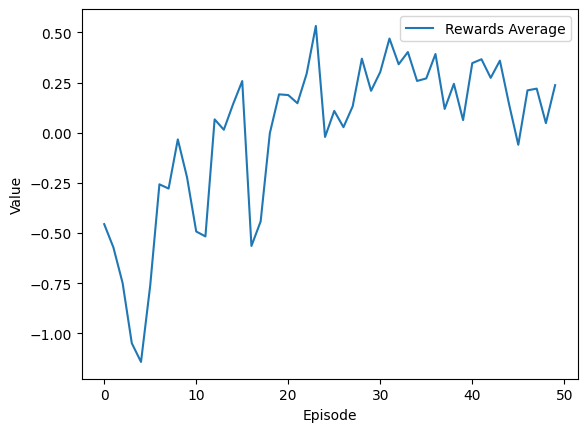

<module 'matplotlib.pyplot' from '/home/jprodanov/resource-elastisity-nancy/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [15]:
import matplotlib.pyplot as plt

plt.plot(avg_rewards, label='Rewards Average')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()
plt

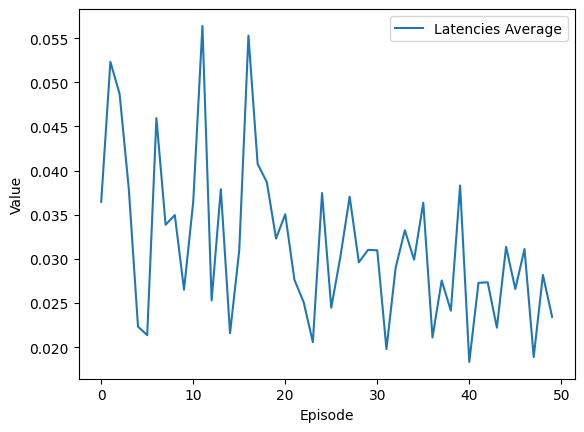

<module 'matplotlib.pyplot' from '/home/jprodanov/resource-elastisity-nancy/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [12]:
plt.plot(latencies_avg, label='Latencies Average')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.show()
plt

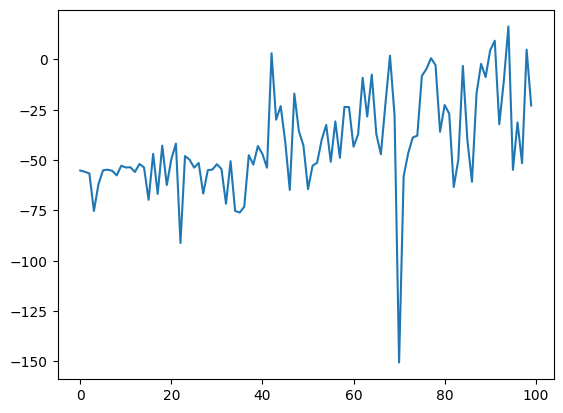

In [12]:
plt.plot(sum_rewards, label='Summed Rewards')
